In [1]:
import numpy as np
import pandas as pd

# Data Ingestion

In [14]:
# previously merged data (Market, Futures, Onchain, Trends)
df = pd.read_csv("Data/merged.csv", parse_dates=['Date']).iloc[:, 1:]
df2 = pd.read_csv("Data/latest_combined_sentiments.csv", parse_dates=['date']).iloc[:, 1:]
df3 = pd.read_csv("Data/ethereum.csv", parse_dates=['Date']).iloc[:, 1:]

# Data Preprocessing

In [15]:
# Changing column names for Ethereum dataset
df3.columns = ["Date"] + [c + "_eth" for c in df3.columns[1:]]
df3

,Date,Price_eth,Open_eth,High_eth,Low_eth,Vol._eth
0,2021-01-04,1042.40,977.76,1158.27,894.24,5190
1,2021-01-05,1099.52,1042.48,1131.56,976.91,3250
2,2021-01-06,1207.77,1099.77,1210.78,1060.67,3750
3,2021-01-07,1224.35,1208.71,1286.81,1153.09,2710
4,2021-01-08,1215.73,1224.33,1271.08,1069.25,2710
...,...,...,...,...,...,...
973,2023-09-04,1630.51,1635.86,1643.31,1618.49,178250
974,2023-09-05,1634.46,1630.53,1647.67,1610.02,219790
975,2023-09-06,1633.18,1634.46,1667.08,1610.49,240730
976,2023-09-07,1648.09,1633.18,1658.04,1624.07,243550


In [21]:
# Merge the two datasets on the date columns
merged_data = pd.merge(df, df2, left_on="Date", right_on="date", how="left")
merged_data = pd.merge(merged_data, df3, left_on="Date", right_on="Date", how="left")

# Drop duplicate columns and unnecessary columns
merged_data.drop(columns=["date"], inplace=True)
merged_data.columns

Index(['Date', 'Price_market', 'Open_market', 'High_market', 'Low_market',
       'Vol._market', 'asks_market', 'bids_market', 'bidAskSpread_market',
       'rank_market',
       ...
       'Vader_Comp', 'Vader_Pos', 'Vader_Neg', 'Vader_Neu', 'Sentiment_Label',
       'Price_eth', 'Open_eth', 'High_eth', 'Low_eth', 'Vol._eth'],
      dtype='object', length=140)

In [22]:
# Impute missing values for the sentiment numerical columns with their mean
sentiment_numeric_cols = ["Vader_Comp", "Vader_Pos", "Vader_Neg", "Vader_Neu"]
for col in sentiment_numeric_cols:
    merged_data[col].fillna(merged_data[col].mean(), inplace=True)

# Impute missing values for the categorical sentiment column with its mode
merged_data["Sentiment_Label"].fillna(
    merged_data["Sentiment_Label"].mode()[0], inplace=True
)

# Impute missing values for the Vol._futures column with its mean
merged_data["Vol._futures"].fillna(merged_data["Vol._futures"].mean(), inplace=True)

# Check if there are any remaining missing values
remaining_missing = merged_data.isnull().sum().sum()

remaining_missing

0

In [23]:
def createPriceChangePct100(df):
    df.loc[:, "PriceChange"] = -df["Price_market"].diff(periods=-1)  # -(curr - next)
    df.loc[:, "PriceChangePct"] = -df["Price_market"].pct_change(
        periods=-1
    )  # -(curr - next)/curr
    df.loc[:, "PriceChangePct100"] = df["PriceChangePct"] * 100
    df = df[:-1].reset_index(drop=True)  # drop last row with NaN PriceChangePct
    return df


merged_data = createPriceChangePct100(merged_data)

In [24]:
# Create lagged price change for autoregression (in our time series models)
merged_data["PriceChangeLag"] = merged_data["PriceChange"].shift()
merged_data.dropna(inplace=True)
merged_data

,Date,Price_market,Open_market,High_market,Low_market,Vol._market,asks_market,bids_market,bidAskSpread_market,rank_market,...,Sentiment_Label,Price_eth,Open_eth,High_eth,Low_eth,Vol._eth,PriceChange,PriceChangePct,PriceChangePct100,PriceChangeLag
1,2021-01-05,33991.5,32015.4,34414.7,30010.5,202130.0,4.852857e+07,2.696802e+07,0.599972,863.808726,...,positive,1099.52,1042.48,1131.56,976.91,3250,2801.7,0.076147,7.614722,1968.9
2,2021-01-06,36793.2,33999.3,36934.8,33408.3,227560.0,6.131225e+07,3.261763e+07,0.583837,738.868091,...,positive,1207.77,1099.77,1210.78,1060.67,3750,2667.0,0.067587,6.758709,2801.7
3,2021-01-07,39460.2,36798.5,40340.9,36361.2,249600.0,7.347133e+07,3.224854e+07,0.643784,701.389543,...,positive,1224.35,1208.71,1286.81,1153.09,2710,1139.1,0.028057,2.805713,2667.0
4,2021-01-08,40599.3,39466.4,41921.7,36613.4,251290.0,5.854821e+07,3.492305e+07,0.682708,779.504457,...,positive,1215.73,1224.33,1271.08,1069.25,2710,-5055.0,-0.142217,-14.221690,1139.1
5,2021-01-11,35544.3,38195.3,38217.2,30411.6,251040.0,2.670912e+07,3.533249e+07,0.975458,1042.351689,...,positive,1091.47,1255.84,1257.30,917.96,4190,-1468.2,-0.043086,-4.308592,-5055.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
668,2023-08-31,25937.3,27300.6,27464.5,25731.0,69110.0,1.815968e+07,3.612133e+07,7.179025,444.801895,...,positive,1645.82,1705.23,1723.95,1634.74,355270,-134.1,-0.005197,-0.519703,-1361.5
669,2023-09-01,25803.2,25938.3,26144.9,25361.9,58080.0,1.797838e+07,4.695970e+07,7.182452,446.331822,...,positive,1629.00,1645.82,1654.39,1603.67,319190,-13.0,-0.000504,-0.050407,-134.1
670,2023-09-05,25790.2,25824.4,25864.0,25596.3,28400.0,2.222364e+07,5.251132e+07,7.174868,381.243573,...,positive,1634.46,1630.53,1647.67,1610.02,219790,-32.2,-0.001250,-0.125010,-13.0
671,2023-09-06,25758.0,25790.1,26018.4,25411.7,37780.0,2.179251e+07,5.297339e+07,7.167681,375.630506,...,positive,1633.18,1634.46,1667.08,1610.49,240730,491.8,0.018735,1.873538,-32.2


# Feature Selection (using Feature Importance)

In [25]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Define features (X) and target (y)
X = merged_data.drop(
    columns=[
        "Date",
        "Sentiment_Label",
        "PriceChangePct100",
        "PriceChangePct",
        "PriceChange",
    ]
)  # Drop non-numeric column 'Sentiment_Label' and target
y = merged_data["PriceChange"]

# merged_data.to_csv("all_features.csv", index=False)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Initialize and train a Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Extract feature importance
feature_importance = rf.feature_importances_
features_df = pd.DataFrame(
    {"Feature": X.columns, "Importance": feature_importance}
).sort_values(by="Importance", ascending=False)

THRESHOLD = 0.01
selected_features = features_df[features_df["Importance"] >= THRESHOLD][
    "Feature"
].to_list()

selected_features

['Price_eth',
 'addresses_active_count_onchain',
 'RevUSD_market',
 'Vader_Comp',
 'Vol._futures',
 'Vader_Neu',
 'bids_market',
 'supply_miner_held_by_all_addresses_within_one_hop_of_a_mining_entity_native_units_onchain',
 'volatility_market',
 'AdrActCnt_market',
 'issuance_total_usd_onchain',
 'SplyFF_market',
 'transactions_transfers_value_median_usd_onchain',
 'Vol._eth',
 'network_distribution_factor_onchain',
 'ROI30d_market',
 'PriceChangeLag',
 'addresses_with_balance_greater_than_1k_native_units_count_onchain',
 'Low_eth',
 'Vol._market',
 'Vader_Pos',
 'estimated_transaction_volume_usd_onchain',
 'bidAskSpread_market',
 'hash_rate_mean_onchain',
 'HashRate_market',
 'TxCnt_market',
 'VtyDayRet30d_market',
 'supply_held_by_top_100_addresses_onchain',
 'Vader_Neg']

<Axes: ylabel='Feature'>

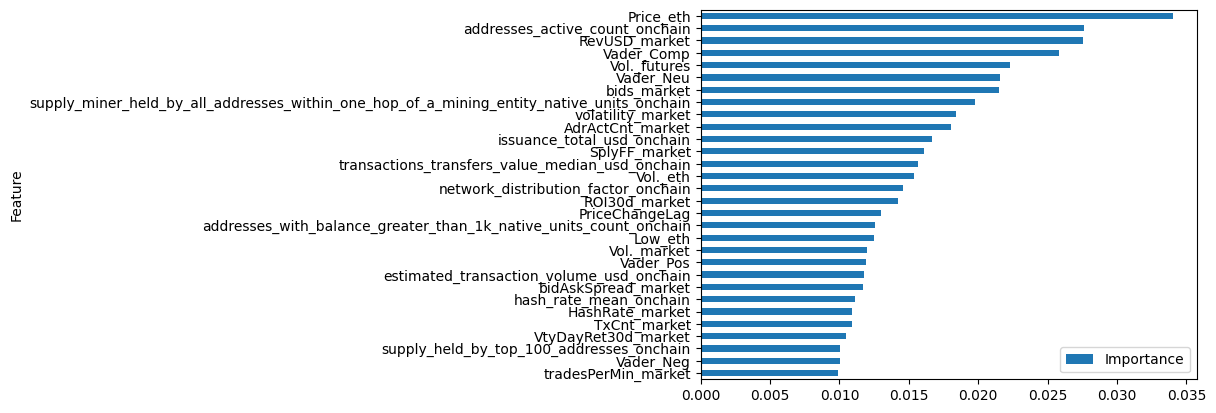

In [26]:
features_df[len(selected_features)::-1].plot.barh(x='Feature', y='Importance')

# Target Feature Scaling

In [27]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X_selected = merged_data[selected_features + ['Date']]

# Split the dataset into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(
    X_selected, y, test_size=0.2, random_state=42, shuffle=False
)  # No shuffle to preserve time order

# Scale train and test separately to avoid data leakage
std_scaler = StandardScaler()
y_train = std_scaler.fit_transform(np.reshape(y_train, (-1, 1))).ravel()
y_val = std_scaler.fit_transform(np.reshape(y_val, (-1, 1))).ravel()
std_scaler.var_, std_scaler.mean_  # to be used in swing trading simulation

(array([619597.97351221]), array([14.6162963]))

# Exporting Dataset

In [28]:
X_train['target'] = y_train
X_train['test'] = False

X_val['target'] = y_val
X_val['test'] = True

final = pd.concat([X_train, X_val])
final.iloc[:, -3:]

,Date,target,test
1,2021-01-05,1.612101,False
2,2021-01-06,1.535109,False
3,2021-01-07,0.661790,False
4,2021-01-08,-2.878639,False
5,2021-01-11,-0.828492,False
...,...,...,...
668,2023-08-31,-0.188931,True
669,2023-09-01,-0.035084,True
670,2023-09-05,-0.059476,True
671,2023-09-06,0.606220,True


In [30]:
final.to_csv("Data/final_data.csv", index=False)